<a href="https://colab.research.google.com/github/neynehaa/Pneumonia-detection-with-CNN/blob/main/pneumonia_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pneumonia Detection using X-Rays

**Setup and Environment Configuration**

Installing necessary packages
Configuring Google Drive access
Setting up directory structure


**Data Preparation and Exploration**

Loading the X-ray dataset
Exploring the dataset structure
Visualizing sample images
Dataset statistics analysis


**Data Preprocessing**

Transformations (resize, normalization, etc.)
Creating training, validation, and test splits
Setting up data loaders


**Model Architecture**

Designing a CNN architecture for medical image
Configuring model hyperparameters
Implementing the model in PyTorch


**Training Loop**

Setting up loss function and optimizer
Implementing training and validation loops
Early stopping and learning rate scheduling
Tracking metrics (accuracy, loss)
Visualizing training progress


**Model Evaluation**

Testing the model on the test set
Confusion matrix visualization
Class-wise performance metrics
Visualizing model predictions


**Model Interpretation**

Feature visualization techniques
Grad-CAM for visual explanations
Understanding what the model has learned


**Deployment**

Saving and loading the trained model
Making predictions on new images
Simple inference pipeline


**Performance Optimization**

Hyperparameter tuning strategies
Model architecture variations
Tips for improving accuracy



---



**Step 1: Importing necessary libraries**

In [ ]:
# PyTorch - Main deep learning framework
import torch
import torch.nn as nn  # Neural network modules, layers, etc.
import torch.optim as optim  # Optimization algorithms like SGD, Adam
from torch.utils.data import Dataset, DataLoader  # For handling datasets and loading data in batches

# torchvision - Package with vision datasets, model architectures and image transformations
import torchvision
import torchvision.transforms as transforms  # For image preprocessing
from torchvision.datasets import MNIST  # Dataset for handwritten digits

# Visualization libraries
import matplotlib.pyplot as plt  # Standard plotting library
import seaborn as sns  # Enhanced visualization library built on matplotlib
from PIL import Image  # Image processing library

# Utilities
import numpy as np  # Numerical computations
import pandas as pd  # Data manipulation and analysis
import os  # Operating system interfaces
import random  # For random number generation
from sklearn.metrics import confusion_matrix, classification_report  # For model evaluation
import time  # For timing operations

from google.colab import drive
drive.mount('/content/drive')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Setup complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda:0
Setup complete!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 2:Loading, normallization and splitting the dataset**

In [ ]:

data_path = '/content/drive/MyDrive/Dataset'  # Path relative to notebook location

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor (also scales pixel values to [0,1])
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean=0.5 and std=0.5 (adjust based on your dataset)
])


full_dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transform)

# Print basic dataset information
print(f"Total dataset size: {len(full_dataset)}")
print(f"Image shape: {full_dataset[0][0].shape}")  # Format: [channels, height, width]
print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Classes: {full_dataset.classes}")

# Create train/validation/test splits
# A common split is 70-15-15 or 80-10-10 (train-val-test)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Use torch.utils.data.random_split to split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Keep the split reproducible
)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total dataset size: 2000
Image shape: torch.Size([3, 128, 128])
Number of classes: 2
Classes: ['normal', 'pneumonic']
Training set size: 1400
Validation set size: 300
Test set size: 300


Setting up data loaders...
Number of training batches: 44
Number of validation batches: 10
Number of test batches: 10
Visualizing a batch from the training data:


Batch shape: torch.Size([32, 3, 128, 128])
Labels shape: torch.Size([32])
Labels of displayed images: [1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 0]


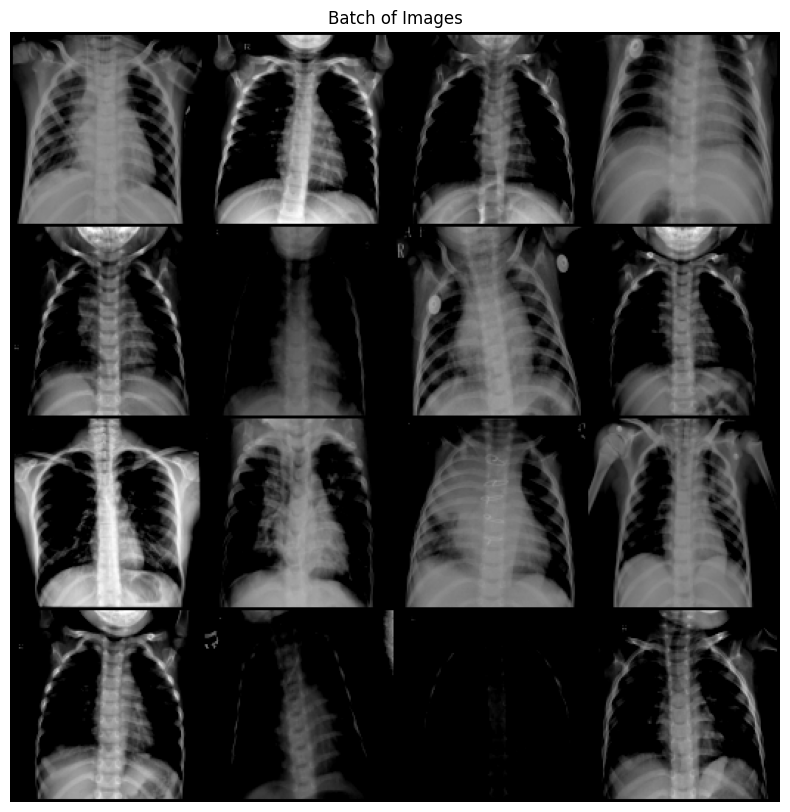

In [ ]:
# Creating Data Loaders
print("Setting up data loaders...")

# Define batch size - typically powers of 2 (16, 32, 64, etc.) for efficiency
batch_size = 32

# Create data loaders for each dataset split
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,      # Shuffle training data to avoid learning order patterns
    num_workers=2      # Number of subprocesses for data loading
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,     # No need to shuffle validation data
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,     # No need to shuffle test data
    num_workers=2
)

# # Print data loader information
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Let's visualize a single batch to understand batched data
def visualize_batch(dataloader):
    # Get a batch of images and labels
    images, labels = next(iter(dataloader))

    # Print batch information
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

    # Create a grid of images
    grid = torchvision.utils.make_grid(images[:16], nrow=4)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.title('Batch of Images')
    plt.axis('off')

    # Print the corresponding labels
    print(f"Labels of displayed images: {labels[:16].numpy()}")

    plt.show()

print("Visualizing a batch from the training data:")
visualize_batch(train_loader)

In [ ]:
# Define CNN Model Architecture for OCR
class OCRModel(nn.Module):
    def __init__(self, num_classes=10):
        super(OCRModel, self).__init__()

        # Feature extraction layers
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Assuming grayscale input (1 channel)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Calculate the size of features after convolution dynamically
        # Pass a dummy input through the convolutional layers to get the actual output size
        dummy_input = torch.randn(1, 3, 128, 128) # Assuming input size is 128x128 and 3 channels
        dummy_output = self.features(dummy_input)
        self.feature_size = dummy_output.view(-1).shape[0] # Get the flattened size

        # Classification layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(self.feature_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Extract features using convolutional layers
        x = self.features(x)

        # Flatten the features
        x = x.view(-1, self.feature_size)

        # Apply classification layers
        x = self.classifier(x)

        return x
# Initialize the model
num_classes = len(full_dataset.classes)  # Number of character classes
model = OCRModel(num_classes=num_classes)

# Move model to the appropriate device (GPU if available)
model = model.to(device)

# Print model summary
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

OCRModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=32768, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p

In [ ]:
# ----------------------------
# Block D: Loss and Optimizer
# ----------------------------

import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optional: Learning rate scheduler (can help with convergence)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) #after every 10 epochs, lrnew=lrold*0.1




Epoch [1/10], Train Loss: 1.0877, Val Loss: 3.7661, Train Acc: 0.8507, Val Acc: 0.5333
Epoch [2/10], Train Loss: 0.1560, Val Loss: 0.1766, Train Acc: 0.9443, Val Acc: 0.9433
Epoch [3/10], Train Loss: 0.1322, Val Loss: 0.2333, Train Acc: 0.9529, Val Acc: 0.9233
Epoch [4/10], Train Loss: 0.1098, Val Loss: 0.1456, Train Acc: 0.9621, Val Acc: 0.9467
Epoch [5/10], Train Loss: 0.0712, Val Loss: 0.2013, Train Acc: 0.9700, Val Acc: 0.9300
Epoch [6/10], Train Loss: 0.0661, Val Loss: 0.1631, Train Acc: 0.9771, Val Acc: 0.9533
Epoch [7/10], Train Loss: 0.0607, Val Loss: 0.1136, Train Acc: 0.9750, Val Acc: 0.9600
Epoch [8/10], Train Loss: 0.0494, Val Loss: 0.2010, Train Acc: 0.9807, Val Acc: 0.9267
Epoch [9/10], Train Loss: 0.0610, Val Loss: 0.1336, Train Acc: 0.9729, Val Acc: 0.9600
Epoch [10/10], Train Loss: 0.0302, Val Loss: 0.1952, Train Acc: 0.9886, Val Acc: 0.9533


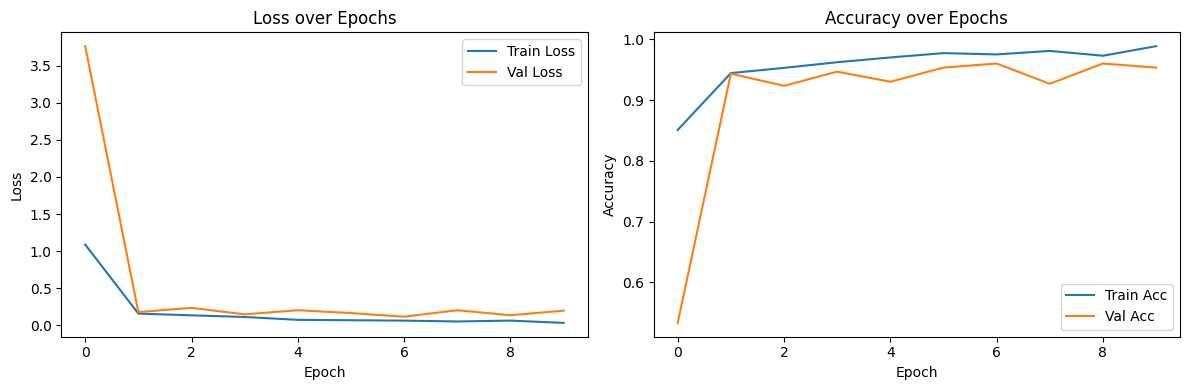

In [ ]:
import time
from IPython.display import clear_output

# Set training hyperparameters
num_epochs = 10
learning_rate = 0.001

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store metrics for later plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss, correct, total = 0.0, 0, 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print statistics every 100 batches (adjust as needed)
        if (i + 1) % 100 == 0:
            clear_output(wait=True)  # Clear previous output
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], "
                  f"Train Loss: {running_loss / total:.4f}, Train Acc: {correct / total:.4f}")

    # Calculate epoch-wise training loss and accuracy
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)  # Store for later plotting
    train_accuracies.append(train_acc)

    # -----------------------------------
    # Validation step:
    # -----------------------------------
    model.eval()  # Set the model to evaluation mode
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():  # No need to calculate gradients during validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)  # Store for later plotting
    val_accuracies.append(val_acc)

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Plotting after training is complete
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("training_progress.png")  # Save the plot
plt.show()  # Display the plot

**EVALUATION**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Evaluate on test set
model.eval()
test_loss, correct, total = 0.0, 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_acc = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 0.2111, Test Accuracy: 0.9467


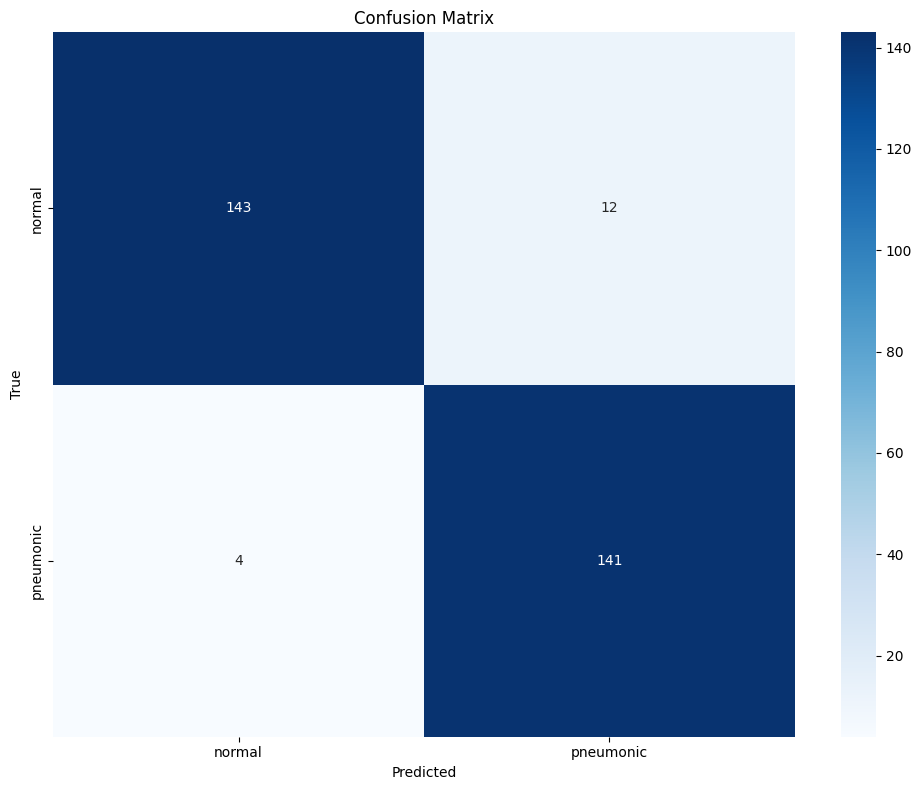

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


In [ ]:
import os
save_path = os.path.join('/content/drive/MyDrive/pneumonic', 'pneumonic.pth') # Replace 'your_folder'
torch.save(model.state_dict(), save_path)
print("Model saved to pneumonia.pth")


Model saved to pneumonia.pth


In [ ]:
from torchvision import transforms
from PIL import Image

# Sample inference (replace with your image)
image_path = "/content/drive/MyDrive/Dataset/healthy.jpeg"
img = Image.open(image_path).convert('RGB')  # Convert to RGB

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to the size used during training
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Match your training normalization
])

img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension
output = model(img_tensor)
_, pred = torch.max(output, 1)

print("Predicted class:", full_dataset.classes[pred.item()])

Predicted class: normal


In [ ]:
# to calculate accuracy, precision and f1score

from sklearn.metrics import accuracy_score, precision_score, f1_score

# Assuming 'all_preds' and 'all_labels' are already defined from your code
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted') # Use 'weighted' for multiclass
f1 = f1_score(all_labels, all_preds, average='weighted') # Use 'weighted' for multiclass

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9467
Precision: 0.9480
F1 Score: 0.9467


In [ ]:
# prompt: code for live demo where we can upload image and it can do prediction

from google.colab import files
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the saved model
model_path = '/content/drive/MyDrive/pneumonic/pneumonic.pth'  # Replace with your model path
model = OCRModel(num_classes=len(full_dataset.classes)) # Assuming you have full_dataset defined
model.load_state_dict(torch.load(model_path))
model.to(device)  # Move the model to the device
model.eval()  # Set the model to evaluation mode


def predict_image(uploaded_image):
    try:
        # Preprocess the uploaded image
        img = Image.open(uploaded_image).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))  # Normalize as per your training
        ])
        img_tensor = transform(img).unsqueeze(0).to(device)

        # Perform prediction
        with torch.no_grad():
            output = model(img_tensor)
            _, pred = torch.max(output, 1)

        predicted_class = full_dataset.classes[pred.item()]
        return predicted_class

    except Exception as e:
        return f"Error during prediction: {e}"


# Upload image through the interface
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    predicted_class = predict_image(fn)
    print("Predicted Class:", predicted_class)


Saving Start.png to Start.png
User uploaded file "Start.png" with length 42899 bytes
Predicted Class: normal


In [ ]:
!pip install gradio  # Uncomment if you haven't installed gradio yet
import gradio as gr
from PIL import Image, ImageOps  # Import ImageOps
# import numpy as np
# import torch
# import torchvision.transforms as transforms

def predict_image(image):
    try:
        # Preprocess the uploaded image (default inversion + mirroring)
        img = Image.open(image).convert('RGB')

        # Mirror the image horizontally
        img = ImageOps.mirror(img)

        img_np = np.array(img)
        img_inverted = 255 - img_np  # Invert using NumPy
        img = Image.fromarray(img_inverted.astype('uint8'))  # Convert back to PIL Image

        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),  # Convert to tensor
            transforms.Normalize((0.5,), (0.5,))  # Normalize as per your training
        ])
        img_tensor = transform(img).unsqueeze(0).to(device)

        # Perform prediction
        with torch.no_grad():
            output = model(img_tensor)
            _, pred = torch.max(output, 1)

        predicted_class = full_dataset.classes[pred.item()]
        return predicted_class

    except Exception as e:
        return f"Error during prediction: {e}"

iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="filepath"),  # Use filepath for uploaded images
    outputs="text",
    live=True,  # Enable live prediction
    title="Real-time OCR Prediction",
    description="Upload an image real-time predictions."
)

iface.launch(share=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.9 MB/s eta 0:00:00
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://36a24db5e2a9e44f69.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
